In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pdb
from tqdm import tqdm

# LQR

In [15]:
# LQR formula
# Use torch tensor to calculate the LQR
def LQR_PF(A, B, N, Q, R, Qf, T, x0):
    """
    Input:
        A, B: system dynamics
        Qf: terminal cost
        Q, R: state and control cost
        N: cross term
        T: time horizon
        x0: initial state
    Return:
        P: Riccati matrix
        F: feedback gain
        J: optimal cost
    """

    P = list(range(T+1))
    F = list(range(T))
    P[T] = Qf
    for t in range(T-1, -1, -1):
        F[t] = -torch.inverse(R + B.t() @ P[t+1] @ B) @ (B.t() @ P[t+1] @ A + N.t())
        P[t] = Q + A.t() @ P[t+1] @ A - (A.t() @ P[t+1] @ B + N) @ torch.inverse(R + B.t() @ P[t+1] @ B) @ (B.t() @ P[t+1] @ A + N.t())

    J = 0
    x = x0
    for t in range(T):
        u = F[t] @ x
        if t == T-1:
            J += x.t() @ Qf @ x
        else:
            J += x.t() @ Q @ x + u.t() @ R @ u + x.t() @ N @ u
        x = A @ x + B @ u
    
    return P, F, J


In [16]:
# Test with 1D system
# f(x, u) = x + u
# J = 1.618 * x_final^2 + \sum x^2 + u^2
# A = 1, B = 1
# Q = 1, R = 1, Qf = 1.618, N = 0
# T = 5
# x0 = 1
# Verify the result with the formula. Correct.

A = torch.tensor([[1.]])
B = torch.tensor([[1.]])
Q = torch.tensor([[1.]])
R = torch.tensor([[1.]])
Qf = torch.tensor([[1.618]])
N = torch.tensor([[0.]])
T = 5
x0 = torch.tensor([[1.]])
P, F, J = LQR_PF(A, B, N, Q, R, Qf, T, x0)

print("P:")
print(P)
print("F:")
print(F)
print("J:")
print(J)

P:
[tensor([[1.6180]]), tensor([[1.6180]]), tensor([[1.6180]]), tensor([[1.6180]]), tensor([[1.6180]]), tensor([[1.6180]])]
F:
[tensor([[-0.6180]]), tensor([[-0.6180]]), tensor([[-0.6180]]), tensor([[-0.6180]]), tensor([[-0.6180]])]
J:
tensor([[1.6180]])


# MPC_simple

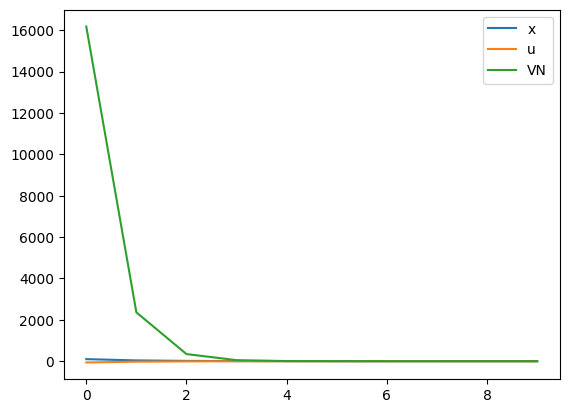

In [ ]:
# Construct MPC problem
# Use float32

DTYPES = torch.float32
torch.set_default_dtype(DTYPES)
MPC_T = 10 # MPC time horizon
A = torch.tensor([[1.]])
B = torch.tensor([[1.]])
Q = torch.tensor([[1.]])
R = torch.tensor([[1.]])
Qf = nn.Parameter(torch.tensor([[1.618]])) # Trainable
N = torch.tensor([[0.]])
T = 1 # OCP time horizon
nx = 1
nu = 1

x_init = torch.tensor([[100.]])

def mpc(A, B, N, Q, R, Qf, T, x_init):
    x = x_init
    x_list = []
    u_list = []
    VN_list = []
    for i in range(MPC_T):
        P, F, J = LQR_PF(A, B, N, Q, R, Qf, T, x)
        u = F[0] @ x
        x_list.append(x)
        u_list.append(u)
        x = A @ x + B @ u
        VN_list.append(J)
    return x_list, u_list, VN_list

x_list, u_list, VN_list = mpc(A, B, N, Q, R, Qf, T, x_init)

# print('x_list:')
# print(x_list)
# print('u_list:')
# print(u_list)
# print('VN_list:')
# print(VN_list)

x_plot = [x[0].item() for x in x_list]
u_plot = [u[0].item() for u in u_list]
VN_plot = [VN.item() for VN in VN_list]

import matplotlib.pyplot as plt
plt.plot(x_plot, label='x')
plt.plot(u_plot, label='u')
plt.plot(VN_plot, label='VN')
plt.legend()
plt.show()

## RDP

In [ ]:
# Train the cost function use RDP method

def cost(x, u, is_terminal):
    if is_terminal:
        return x.t() @ Qf @ x
    else:
        return x.t() @ Q @ x + u.t() @ R @ u

def cal_RDP_criteria(VN_list, x_list, u_list, alpha, MPC_T, func, test=False):
    """
    Input:
        VN_list: list of the cost function value
        x_list: list of the state
        u_list: list of the control
        cost_nn: the cost function
        alpha: the weight of the running cost term
        func: the function used to incoporate the RDP inequality into the loss function
        test: whether to print the RDP value
    Return:
        RDP criteria
    """
    loss = 0
    for i in range(MPC_T - 1):
        RDP = (VN_list[i+1] + alpha * cost(x_list[i], u_list[i], False)) - VN_list[i] # Wish RDP <= 0
        if test:
            print(f'RDP{i}: {RDP}')
        loss += func(RDP)
    return loss

loss = cal_RDP_criteria(VN_list, x_list, u_list, 1, MPC_T, lambda x: torch.sign(x), test=True)
print(f'loss: {loss}')
# loss.backward()
# print(Qf.grad)

RDP0: tensor([[0.2910]], grad_fn=<SubBackward0>)
RDP1: tensor([[0.0422]], grad_fn=<SubBackward0>)
RDP2: tensor([[0.0062]], grad_fn=<SubBackward0>)
RDP3: tensor([[0.0009]], grad_fn=<SubBackward0>)
RDP4: tensor([[0.0001]], grad_fn=<SubBackward0>)
RDP5: tensor([[1.9073e-05]], grad_fn=<SubBackward0>)
RDP6: tensor([[2.8163e-06]], grad_fn=<SubBackward0>)
RDP7: tensor([[4.0792e-07]], grad_fn=<SubBackward0>)
RDP8: tensor([[5.9372e-08]], grad_fn=<SubBackward0>)
loss: tensor([[9.]], grad_fn=<AddBackward0>)


# Large Scale test

In [45]:
# Construct MPC problem
# Use float32

DTYPES = torch.float32
torch.set_default_dtype(DTYPES)
MPC_T = 10
A = torch.tensor([[1.]])
B = torch.tensor([[1.]])
Q = torch.tensor([[1.]])
R = torch.tensor([[1.]])
Qf = nn.Parameter(torch.tensor([[2.0]]))
N = torch.tensor([[0.]])
T = 5
nx = 1
nu = 1

n_epoch = 100

loss = 0
for epoch in tqdm(range(n_epoch)):
    x_init = torch.randn(1, 1) * 1000
    x = x_init

    x_list, u_list, VN_list = mpc(A, B, N, Q, R, Qf, T, x_init)
    
    loss += cal_RDP_criteria(VN_list, x_list, u_list, 1, MPC_T, lambda x: torch.tanh(100000 * x))

loss.backward()
print(Qf.grad)

100%|██████████| 100/100 [00:04<00:00, 23.72it/s]


tensor([[-67.2214]])
